**This file predicts drug-drug interaction using protein-drug models**

In this file, we
1. read in drugs of interest, target of interest
2. generate drug-protein interaction model from bindingbd/davis/other dataset
3. use the model to predict target drug-target protein interaction
4. store the interaction as features for each drug
5. Use the features to predict drug-drug interaction

**Connect to Colab environment, import packages**

In [ ]:
%load_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'DeepPurpose')
print(os.listdir(GOOGLE_DRIVE_PATH))
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

Mounted at /content/drive
['.dockerignore', 'CONTRIBUTE.md', '.gitignore', 'Tutorial_2_Drug_Property_Pred_Assay_Data.ipynb', 'README.md', 'LICENSE.md', 'MANIFEST.in', 'setup.cfg', 'setup.py', 'environment.yml', 'requirements.txt', 'Tutorial_1_DTI_Prediction.ipynb', 'build', '.ipynb_checkpoints', 'DeepPurpose.egg-info', 'data', 'docs', 'DEMO', 'DeepPurpose', 'figs', 'toy_data', 'dist', '.git', 'Transformer_nemo', 'Untitled document.gdoc', 'Semester Summary.gslides', 'convert_pickle.ipynb', 'drugdrug_brochado.ipynb', 'drug_drug_davis.ipynb', 'drugdrug.ipynb']


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import torch

**Step 1: Prepare drug-target interaction pair/dataframes from drug files and target files, used for step2 prediction**

Specify the below dataset:
1. **drug_dataset_path**: drugs of interest with encoding (here we need a file containing drug SMILES and corresponding *drug_encoding* we want to use)<br/>
eg. Indigo drug dataset, brochado drug dataset
2. **target_protein_dataset_path**: target of interest with encoding (here we need a file containing protein sequence and corresponding *target_encoding* we want to use)<br/>
eg. all ecoli proteins from string dataset(ecoli4087)





In [ ]:
# TODO: Specify below
drug_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/identifier_with_MACCS.pkl")
target_protein_dataset_path = os.path.join(GOOGLE_DRIVE_PATH, "data/ecoli_4087.pkl") # "ecoli_1421"

In [ ]:
target_data = pd.read_pickle(target_protein_dataset_path)
target_map = target_data.drop_duplicates(subset=['Target Sequence'])
target_map = target_map[["Target Sequence", target_encoding]]
target_map

,Target Sequence,PseudoAAC
0,MKRISTTITTTITITTGNGAG,"[0.03, 0.03, 0.03, 0.0, 0.0, 0.0, 0.0, 0.09, 0..."
1,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...,"[0.056, 0.028, 0.023, 0.027, 0.008, 0.033, 0.0..."
2,MVKVYAPASSANMSVGFDVLGAAVTPVDGALLGDVVTVEAAETFSL...,"[0.061, 0.028, 0.02, 0.022, 0.015, 0.035, 0.02..."
3,MKLYNLKDHNEQVSFAQAVTQGLGKNQGLFFPHDLPEFSLTEIDEM...,"[0.057, 0.021, 0.023, 0.029, 0.005, 0.035, 0.0..."
4,MKKMQSIVLALSLVLVAPMAAQAAEITLVPSVKLQIGDRDNRGYYW...,"[0.034, 0.034, 0.01, 0.025, 0.0, 0.01, 0.02, 0..."
...,...,...
1122,MTDCRYLIKRVIKIIIAVLQLILLFL,"[0.019, 0.039, 0.0, 0.019, 0.019, 0.0, 0.019, ..."
1123,MRNRNLLKFLPGLLICLIVLTSCVPKQKNMPYALTQRSIPQILPLP...,"[0.021, 0.021, 0.028, 0.0, 0.028, 0.028, 0.048..."
1124,MKNRVYESLTTVFSVLVVSSFLYIWFATY,"[0.02, 0.02, 0.02, 0.0, 0.0, 0.02, 0.0, 0.0, 0..."
1125,MNEFKRCMRVFSHSPFKVRLMLLSMLCDMVNNKPQQDKPSDK,"[0.0, 0.038, 0.038, 0.038, 0.026, 0.013, 0.026..."


In [ ]:
# read drug dataset
# TODO: change data path
# indigo: "identifier_with_MACCS.pkl"
# NP_canosmiles: "NPshort_canosmiles_MACCS.pkl"
# NP_supersmiles: "NPshort_supersmiles_MACCS.pkl"


drug_map = pd.read_pickle(drug_dataset_path)
drug_map

,Drug,Full,Code,MACCS
0,AMK,AMIKACIN-0.2 - UNSPECIFIED,C1C(C(C(C(C1NC(=O)C(CCN)O)OC2C(C(C(C(O2)CO)O)N...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,AMX,AMOXICILLIN-1.5,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
2,AMP,AMPICILLIN-8.0,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=CC=C3)N)C(=O...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
3,AZI,AZITHROMYCIN-1.0,CCC1C(C(C(N(CC(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,AZT,AZTREONAM-0.04,CC1C(C(=O)N1S(=O)(=O)O)NC(=O)C(=NOC(C)(C)C(=O)...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
5,CEF,CEFOXITIN-1.0 - UNSPECIFIED,COC1(C2N(C1=O)C(=C(CS2)COC(=O)N)C(=O)O)NC(=O)C...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
6,CFZ,CEFTAZIDIME-0.075,CC(C)(C(=O)O)ON=C(C1=CSC(=N1)N)C(=O)NC2C3N(C2=...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
7,CHL,CHLORAMPHENICOL-1.5 - UNSPECIFIED,C1=CC(=CC=C1C(C(CO)NC(=O)C(Cl)Cl)O)[N+](=O)[O-],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,CIP,CIPROFLOXACIN-0.004 - UNSPECIFIED,C1CC1N2C=C(C(=O)C3=CC(=C(C=C32)N4CCNCC4)F)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,CLA,CLARYTHROMYCIN-5.0 - UNSPECIFIED,CCC1C(C(C(C(=O)C(CC(C(C(C(C(C(=O)O1)C)OC2CC(C(...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Create separate dataframes for each drug**


Dataframe: single drug: all targets

In [ ]:
# TODO: change the names according to dataset
drug_identifier_name = "Drug"
drug_df_arr=[]

for i in range(len(drug_map)):
  print(drug_map[drug_identifier_name][i])
  new_df = target_map.copy()
  new_df["SMILES"] = drug_map[drug_identifier_name][i]
  new_encoding = np.tile(drug_map[drug_encoding][i], (len(target_map),1))  # Copy MACCS
  new_df[drug_encoding] = new_encoding.tolist()
  new_df["drug"] = drug_map[drug_identifier_name][i]
  drug_df_arr.append(new_df)
  # path = os.path.join(GOOGLE_DRIVE_PATH, "Transformer_nemo/drugdrug/",str(i)+".pkl")
  # new_df.to_pickle(path)

AMK
AMX
AMP
AZI
AZT
CEF
CFZ
CHL
CIP
CLA
DOX
ERY
FOS
FUS
GEN
H22
LEV
MIN
NAL
NIT
NOR
OXA
PMB
RIF
SPE
SPI
SM
SMM
TET
TMP
TOB
TRI
VAN
GLUCOSE
GLYCEROL


**Step 2: generate protein-drug interaction features**<br/>
Below code generates features for individual drugs, if feature already
generates, go to next section.

**Load data for training**<br/>
Specify below:<br/>
>**training_dataset**: known drug-protein interaction dataset with *training_drug_encoding* and *training_protein_encoding*<br/>
eg. bindingdb/davis <br/>
Ideally we keep encoding consistent between training and prediction, but naming might be different, that's why we specify both.

In [ ]:
# drug_encoding = "MACCS"
# target_encoding = "PseudoAAC"
training_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/bindingdb_merged_all.pkl")
training_drug_encoding = "MACCS"
training_protein_encoding = "PseudoAAC(target)"

Generate X_train and y_train from training dataset used for training

In [ ]:
def apply_func_train(x):
  try:
    return np.concatenate((x[drug_encoding],x[training_protein_encoding]))

  except:
    return "error"

def load_and_process(dataset):

  df = pd.read_pickle(training_data_path)
  df.dropna(subset=[drug_encoding,training_protein_encoding],inplace=True)
  df['combined']=df.apply(lambda x:apply_func_train(x),axis=1)
  # train_nonzero=train[train['Label']!=0]
  df = df[df['combined']!="error"]

  X=df.combined.tolist()
  y=df['Label'].tolist()
  X=np.array(X)
  y=np.array(y)
  #FIXME!!!!!!!!!!!!!!!!!!!!!!!!
  mask=torch.tensor(y)<30
  y_binary=torch.zeros_like(torch.tensor(y))
  y_binary[mask]=1
  y_binary.tolist()
  y_binary=y_binary.reshape(y_binary.shape[0],1)
  y_binary=y_binary.tolist()
  X=np.array(X)
  y_binary=np.array(y_binary)
  y_binary = y_binary.reshape(-1)
  print(y_binary)
  return X,y_binary


X,y=load_and_process("bindingdb")

/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


[1. 1. 1. ... 0. 0. 0.]


**Train model on training dataset and predict for target drug-target protein pairs**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import PrecisionRecallDisplay
import json

def apply_func(x):
  try:
    return np.concatenate((x[drug_encoding],x[target_encoding]))
  except:
    return "error"

mydict = {}

X_train = X
y_train = y
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train)
for test_df in drug_df_arr:
  test_df.dropna(subset=[drug_encoding,target_encoding],inplace=True)
  test_df['combined']=test_df.apply(lambda x:apply_func(x),axis=1)
  test_df = test_df[test_df['combined']!="error"]
  X_test=test_df.combined.tolist()
  X_test=np.array(X_test)
  y_pred = classifier.predict_proba(X_test)[:, 1]
  mask=torch.tensor(y_train)<0
  mydict[test_df.drug[0].unique()[0]]=y_pred


/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)
/usr/local/lib/python3.10/dist-packages/pandas/core/ops/array_ops.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


Additionaly you can create a binary feature using threshold of your choice

In [ ]:
#TODO
mydict_binary = mydict.copy()
threshold = 0.4
for key,value in mydict.items():
  mask=torch.tensor(value)>threshold
  temp=torch.zeros_like(torch.tensor(value))
  temp[mask]=1
  mydict_binary[key] = temp.tolist()

In [ ]:
#TODO: optionally you can save the dictionary for direct use next time
# with open(os.path.join(GOOGLE_DRIVE_PATH, "data/NPshort_supersmiles_1421ecoli_dictionary.pkl"), 'wb') as fp:
#     pickle.dump(mydict, fp)


**Step 3: Using drug-target features to generate drug-drug interaction  features**

**Read features for each drug**

In [ ]:
# If you saved your dictionary you can load from here
# mydict=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_mydict.pkl"))
mydict['DOX'] #Just for checking

array([0.31      , 0.2425    , 0.2815    , ..., 0.42833333, 0.37      ,
       0.3       ])

**Read in train and test dataset**<br/>
Specify here:
1. training_data_path: drug-drug interaction files of interest (training), contains two or more drugs and interaction score.<br/>
eg. magenta_train_scores
2. testing_data_path: drug-drug interaction files of interest (testing), contains two or more drugs and interaction score.<br/>
eg. magenta_test_scores

In [ ]:
training_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/magenta_train_scores.csv")
testing_data_path = os.path.join(GOOGLE_DRIVE_PATH, "data/magenta_test_scores.csv")

In [ ]:
train = pd.read_csv(training_data_path)
test = pd.read_csv(testing_data_path)
train

,Drug_1,Drug_2,Media,Score
0,AMK,CEF,NaN,1.373500
1,AMK,CHL,NaN,2.729500
2,AMK,CIP,NaN,-0.024000
3,AMK,CLA,NaN,-0.326000
4,AMK,ERY,NaN,1.433500
...,...,...,...,...
222,TRI,SPE,GLUCOSE,0.030442
223,TRI,TET,GLUCOSE,0.483156
224,RIF,SPE,GLUCOSE,0.061049
225,RIF,TET,GLUCOSE,-0.250495


**Calculate feature scores**
Here I use Sigma and Delta Scores

In [ ]:
def sigma(x):
  try:
    return 2/3*np.add(np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]),mydict_binary[x.Media])
  except:
    return np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2])

def delta(x):
  try:
    row = np.add(np.add(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]),mydict_binary[x.Media])
    if row==1:
      return 1
    else:
      return 0
  except:
    row = abs(np.subtract(mydict_binary[x.Drug_1],mydict_binary[x.Drug_2]))
    return row


train['feat1'] = train.apply(lambda x:mydict[x.Drug_1],axis=1)
test['feat1'] = test.apply(lambda x:mydict[x.Drug_1],axis=1)
train['feat2'] = train.apply(lambda x:mydict[x.Drug_2],axis=1)
test['feat2'] = test.apply(lambda x:mydict[x.Drug_2],axis=1)
train['sigma'] = train.apply(lambda x:sigma(x),axis=1)
test['sigma'] = test.apply(lambda x:sigma(x),axis=1)
train['delta'] = train.apply(lambda x:delta(x),axis=1)
test['delta'] = test.apply(lambda x:delta(x),axis=1)

train

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta
0,AMK,CEF,NaN,1.373500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3655555555555556, 0.2, 0.21, 0.245, 0.3, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,CHL,NaN,2.729500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.31916666666666665, 0.185, 0.21, 0.16, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,AMK,CIP,NaN,-0.024000,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.4, 0.18, 0.165, 0.1825, 0.36, 0.22, 0.3925,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CLA,NaN,-0.326000,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.26, 0.225, 0.26, 0.365, 0.27916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,ERY,NaN,1.433500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.36, 0.18833333333333332, 0.19, 0.2233333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
222,TRI,SPE,GLUCOSE,0.030442,"[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
223,TRI,TET,GLUCOSE,0.483156,"[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
224,RIF,SPE,GLUCOSE,0.061049,"[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
225,RIF,TET,GLUCOSE,-0.250495,"[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
test

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta
0,AMK,AMP,GLYCEROL,-0.822900,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.39, 0.21, 0.19, 0.21666666666666667, 0.31, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,AZI,GLYCEROL,0.565743,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.2383333333333333, 0.185, 0.2033333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,AZT,GLYCEROL,-1.155886,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3871428571428572, 0.25, 0.28, 0.29, 0.35, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,AMK,CEF,GLYCEROL,-1.428765,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3655555555555556, 0.2, 0.21, 0.245, 0.3, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,CHL,GLYCEROL,1.196634,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.31916666666666665, 0.185, 0.21, 0.16, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
5,AMK,TRI,GLYCEROL,-0.499092,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,AMK,NAL,GLYCEROL,0.213711,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.466, 0.07, 0.20333333333333337, 0.145, 0.23...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,AMK,RIF,GLYCEROL,-0.264909,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,AMK,SPE,GLYCEROL,0.733873,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,AMK,TET,GLYCEROL,0.544553,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Combine sigma and delta scores by concatinating them, this will be the drug-drug interaction feature.

In [ ]:
train['combined'] = train.apply(lambda x:np.append(x.sigma,x.delta),axis=1)
test['combined'] = test.apply(lambda x:np.append(x.sigma,x.delta),axis=1)
# indigo_train['feat+delta'] = indigo_train.apply(lambda x:np.append(np.add(x.feat1,x.feat2),x.delta),axis=1)
# indigo_test['feat+delta'] = indigo_test.apply(lambda x:np.append(2/3*np.add(np.add(x.feat1,x.feat2),x.feat3),x.delta),axis=1)
train

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta,combined
0,AMK,CEF,NaN,1.373500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3655555555555556, 0.2, 0.21, 0.245, 0.3, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,CHL,NaN,2.729500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.31916666666666665, 0.185, 0.21, 0.16, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
2,AMK,CIP,NaN,-0.024000,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.4, 0.18, 0.165, 0.1825, 0.36, 0.22, 0.3925,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,AMK,CLA,NaN,-0.326000,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.26, 0.225, 0.26, 0.365, 0.27916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,ERY,NaN,1.433500,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.36, 0.18833333333333332, 0.19, 0.2233333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
222,TRI,SPE,GLUCOSE,0.030442,"[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
223,TRI,TET,GLUCOSE,0.483156,"[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
224,RIF,SPE,GLUCOSE,0.061049,"[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
225,RIF,TET,GLUCOSE,-0.250495,"[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
test

,Drug_1,Drug_2,Media,Score,feat1,feat2,sigma,delta,combined
0,AMK,AMP,GLYCEROL,-0.822900,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.39, 0.21, 0.19, 0.21666666666666667, 0.31, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,AMK,AZI,GLYCEROL,0.565743,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.2383333333333333, 0.185, 0.2033333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,AMK,AZT,GLYCEROL,-1.155886,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3871428571428572, 0.25, 0.28, 0.29, 0.35, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666..."
3,AMK,CEF,GLYCEROL,-1.428765,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3655555555555556, 0.2, 0.21, 0.245, 0.3, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,AMK,CHL,GLYCEROL,1.196634,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.31916666666666665, 0.185, 0.21, 0.16, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666..."
5,AMK,TRI,GLYCEROL,-0.499092,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.45, 0.1, 0.18, 0.09, 0.19666666666666666, 0...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,AMK,NAL,GLYCEROL,0.213711,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.466, 0.07, 0.20333333333333337, 0.145, 0.23...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,AMK,RIF,GLYCEROL,-0.264909,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.3871428571428572, 0.15, 0.26, 0.2375, 0.34,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,AMK,SPE,GLYCEROL,0.733873,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.37, 0.17, 0.1875, 0.2, 0.24, 0.195916666666...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,AMK,TET,GLYCEROL,0.544553,"[0.3833333333333333, 0.13583333333333333, 0.19...","[0.29, 0.26, 0.299, 0.23199999999999998, 0.28,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
len(train['combined'][0])

8174

In [ ]:
test.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
train.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

**Step 4. Train and evaluate drug-drug interaction model.**<br/>
If drug-drug interaction features already created, start from here.

In [ ]:
test=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
train=pd.read_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

,index,Drug_1,Drug_2,Score,sigma,delta,feat1,feat2,combined,feat+delta
0,0,AMK,CEF,1.3735,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.28, 0.12571428571428572, 0.24, 0.2090476190...","[0.39799999999999996, 0.19, 0.2483333333333333...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6779999999999999, 0.3157142857142857, 0.488..."
1,1,AMK,CHL,2.7295,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.28, 0.12571428571428572, 0.24, 0.2090476190...","[0.29, 0.16, 0.215, 0.2353333333333333, 0.29, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.5700000000000001, 0.2857142857142857, 0.454..."
2,2,AMK,CIP,-0.0240,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.28, 0.12571428571428572, 0.24, 0.2090476190...","[0.3675, 0.15, 0.23, 0.24, 0.37, 0.26, 0.44, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.6475, 0.2757142857142857, 0.47, 0.449047619..."
3,3,AMK,CLA,-0.3260,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.28, 0.12571428571428572, 0.24, 0.2090476190...","[0.415, 0.16, 0.23, 0.255, 0.355, 0.3781818181...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.6950000000000001, 0.2857142857142857, 0.47,..."
4,4,AMK,ERY,1.4335,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.28, 0.12571428571428572, 0.24, 0.2090476190...","[0.395, 0.156, 0.23, 0.24100000000000002, 0.33...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.675, 0.2817142857142857, 0.47, 0.4500476190..."
...,...,...,...,...,...,...,...,...,...,...
166,61,SPE,TMP,1.6785,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4225, 0.13266666666666665, 0.17766666666666...","[0.3991666666666667, 0.04, 0.13, 0.08, 0.26, 0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.8049999999999999, 0.236, 0.33, 0.391, 0.545..."
167,62,SPE,VAN,0.8350,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.4225, 0.13266666666666665, 0.17766666666666...","[0.3225, 0.17, 0.35166666666666674, 0.27, 0.28...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.8425, 0.326, 0.44, 0.401, 0.675, 0.49818181..."
168,63,TET,VAN,-1.0180,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.34, 0.2, 0.30857142857142855, 0.26333333333...","[0.3225, 0.17, 0.35166666666666674, 0.27, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.7683333333333333, 0.306, 0.3616666666666667..."
169,64,TOB,VAN,1.6040,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.3125, 0.15, 0.195, 0.21, 0.2233333333333333...","[0.3225, 0.17, 0.35166666666666674, 0.27, 0.28...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.795, 0.36950000000000005, 0.486, 0.43766666..."


In [ ]:
test.combined[0]

array([0., 0., 0., ..., 1., 0., 0.])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.svm import SVR

# 400 50
regr_rf = RandomForestRegressor(n_estimators=50,max_depth=300)
regr_et = ExtraTreesRegressor(n_estimators=500)
regr_xgb = xgb.XGBRegressor(objective="reg:linear", random_state=42)
regr_svm = SVR(kernel='poly',degree=15,C=0.5,epsilon=0.5)

# PrecisionRecallDisplay.from_predictions(y_val,y_pred_val)
# plt.show()

In [ ]:
def plot(y_test,y_pred):
  plt.figure(figsize=(10,10))
  plt.scatter(y_test, y_pred, c='crimson')
  # plt.yscale('log')
  # plt.xscale('log')

  p1 = max(max(y_pred), max(y_test))
  p2 = min(min(y_pred), min(y_test))
  plt.plot([p1, p2], [p1, p2], 'b-')
  plt.xlabel('True Values', fontsize=15)
  plt.ylabel('Predictions', fontsize=15)
  plt.axis('equal')
  plt.show()

In [ ]:
X_train=train['combined'].tolist()
y_train=train.Score.tolist()
X_test=test['combined'].tolist()
y_test=test.Score.tolist()
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
y_test

array([-8.22900319e-01,  5.65742803e-01, -1.15588578e+00, -1.42876527e+00,
        1.19663426e+00, -4.99091616e-01,  2.13710612e-01, -2.64909064e-01,
        7.33872996e-01,  5.44552651e-01, -1.00322887e+00, -5.69714706e-01,
        1.61854455e-01, -1.54294550e+00,  5.05699062e-01,  6.01236099e-01,
       -1.68357778e+00, -7.19116427e-01, -6.86854650e-02,  1.37174600e-03,
        3.44767765e-01, -5.14127611e-01,  2.95160600e-03,  7.99258768e-01,
       -1.92606206e+00, -2.88005284e-01, -8.18404970e-01, -3.68597869e-01,
        2.11498196e-01,  6.93186241e-01,  6.01997790e-01,  7.79279125e-01,
        2.35593700e-03,  5.82641075e-01,  1.41040149e-01,  7.08248489e-01,
        8.40213743e-01,  2.49329914e-01,  1.65879659e-01, -5.53613740e-02,
        1.44993527e-01,  7.57003103e-01, -3.56563850e-02, -2.25134892e-01,
        2.23716491e-01,  7.07501797e-01,  4.08434749e-01, -8.32249547e-01,
       -4.15566000e-01,  6.53079998e-01,  6.40958362e-01,  4.80334034e-01,
       -5.17263136e-01, -

rf 0.6395382395382397


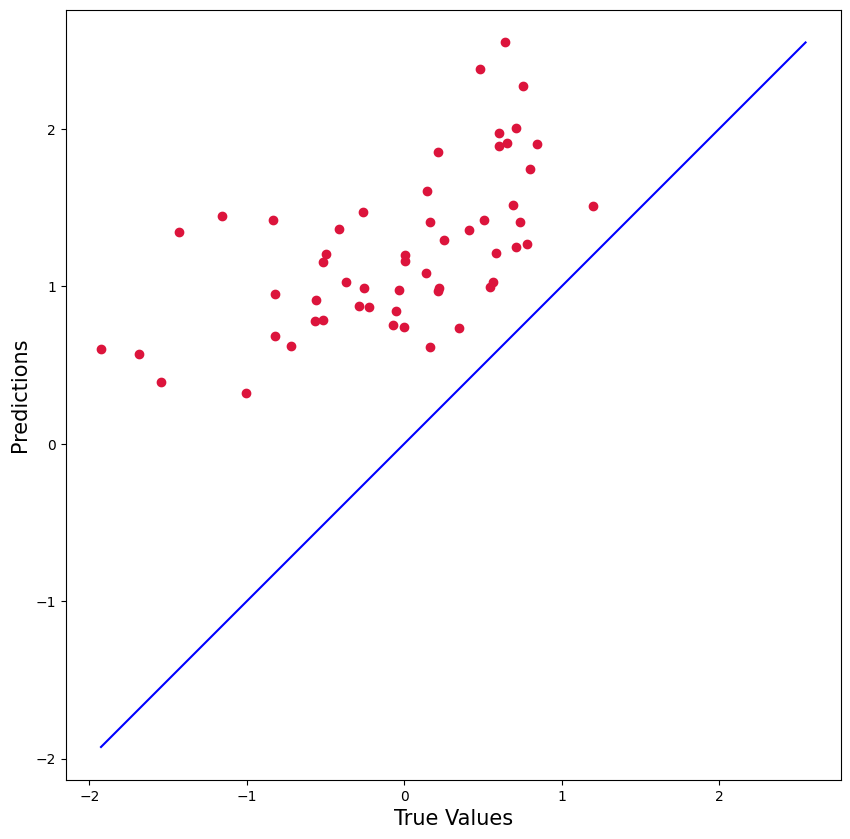

rf 0.6494227994227996


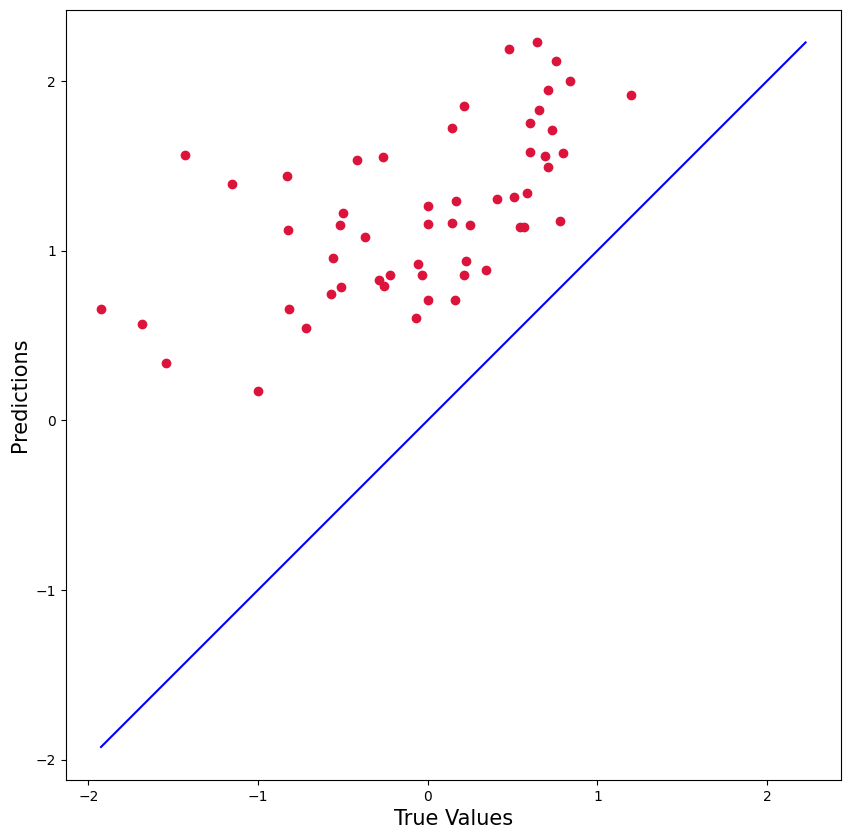

rf 0.6409812409812411


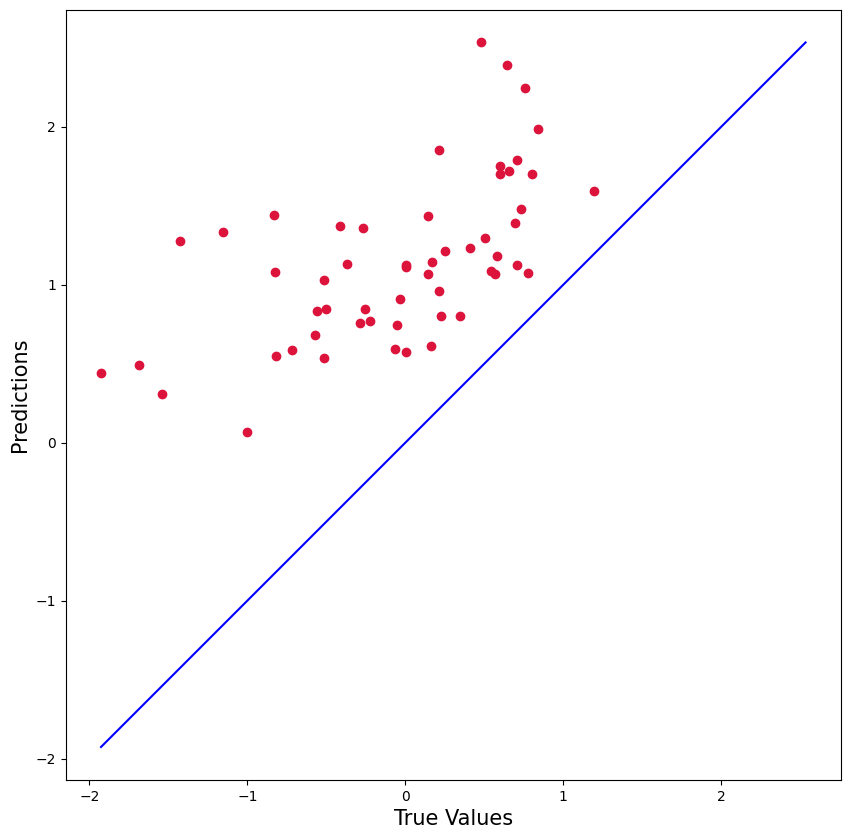

rf 0.6599567099567101


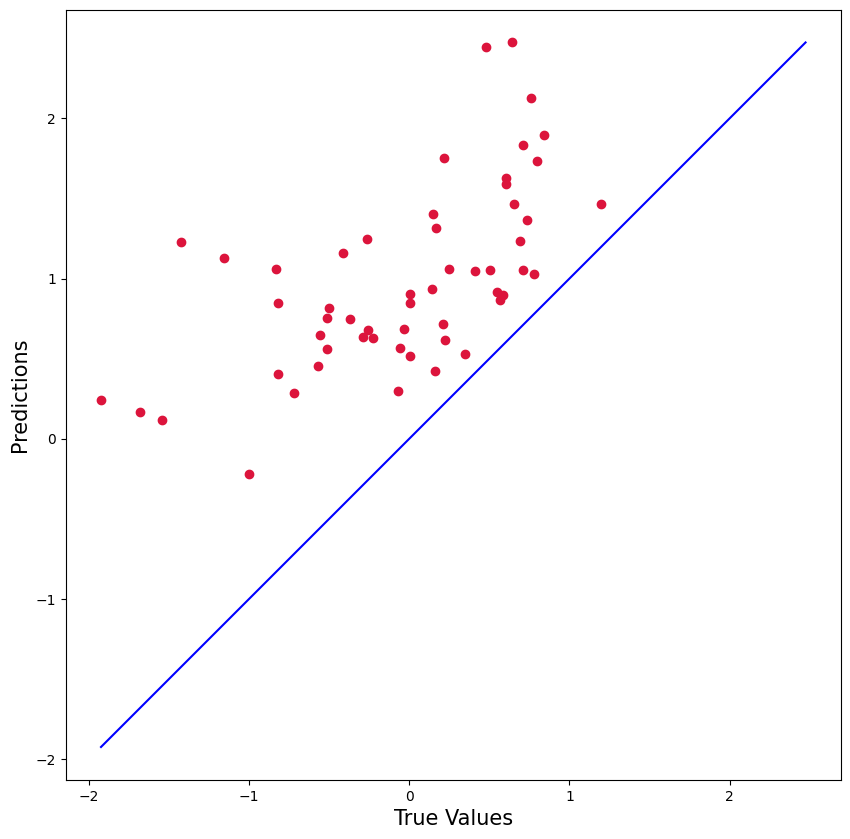

rf 0.6006493506493508


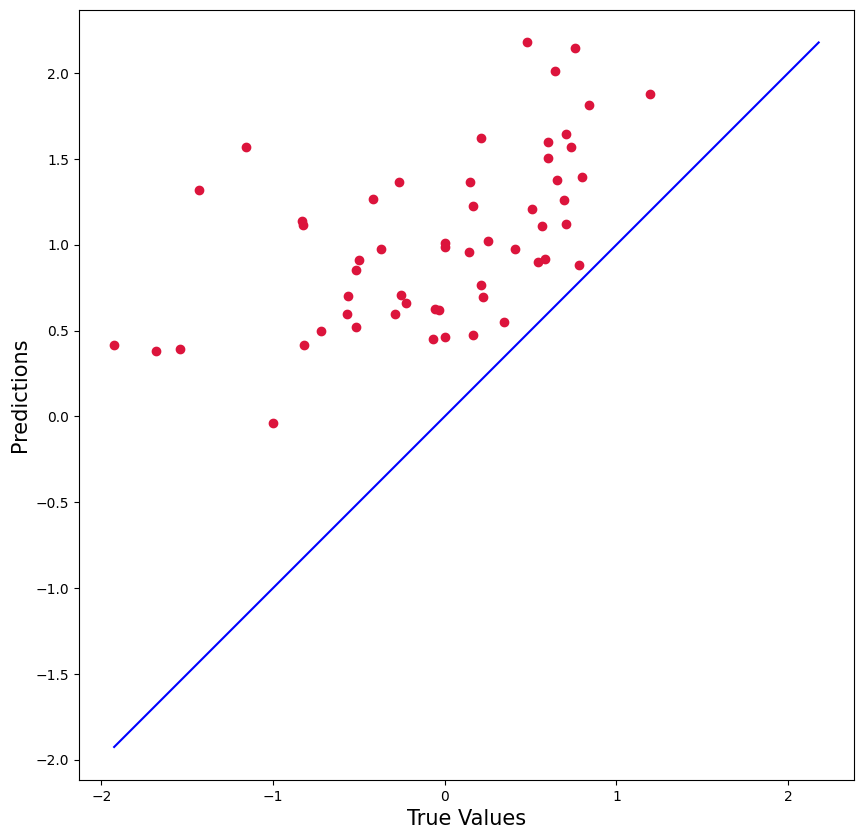

rf 0.6491341991341993


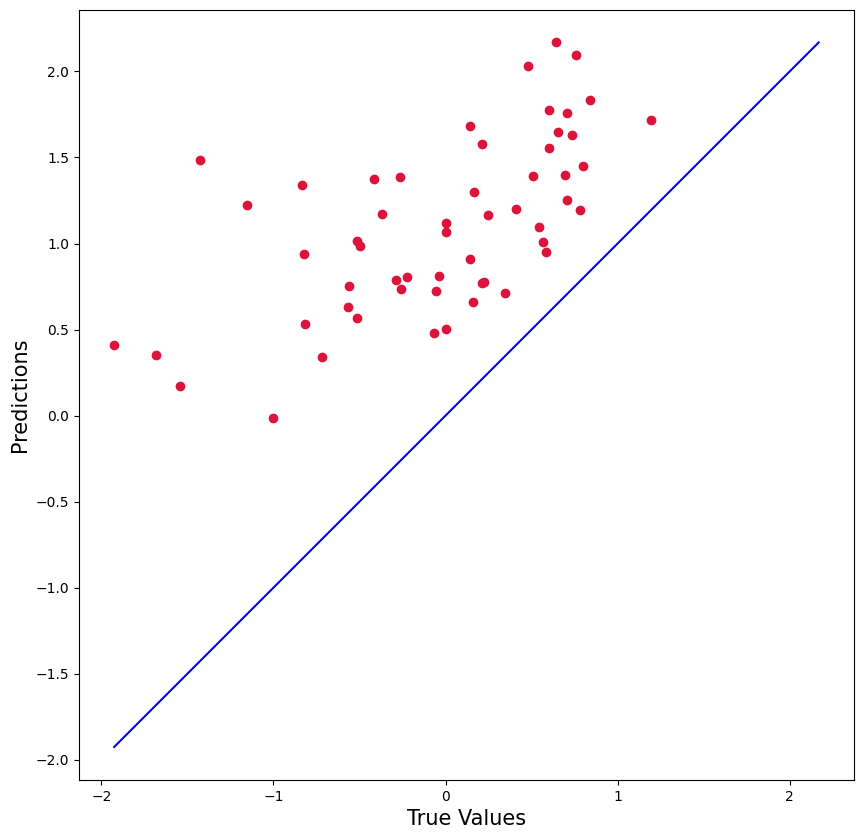

rf 0.6531024531024532


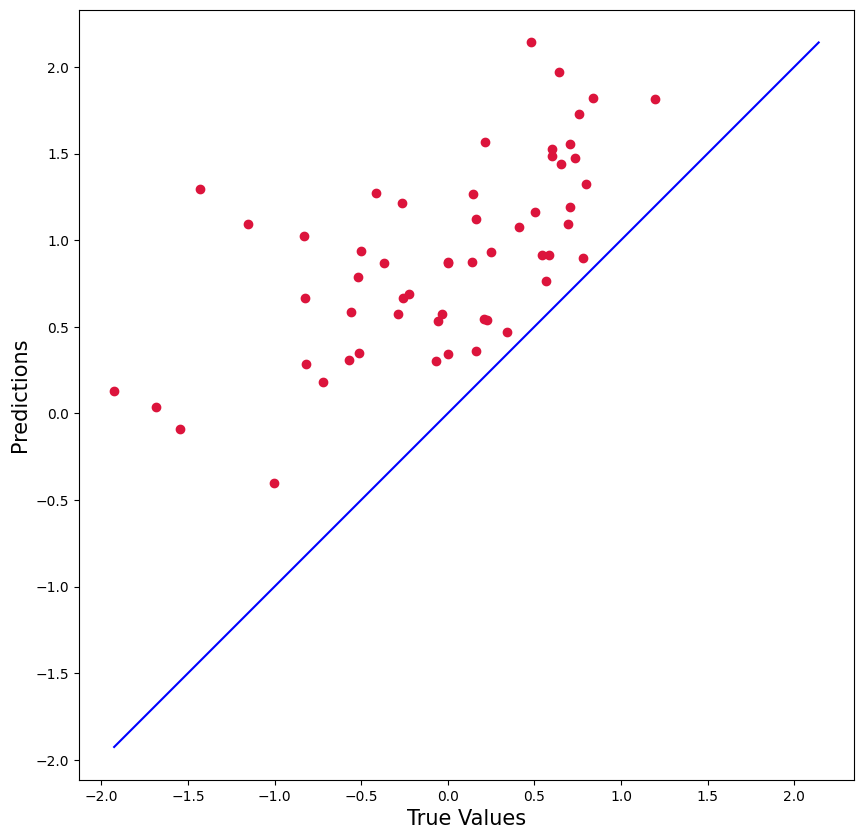

rf 0.6601731601731603


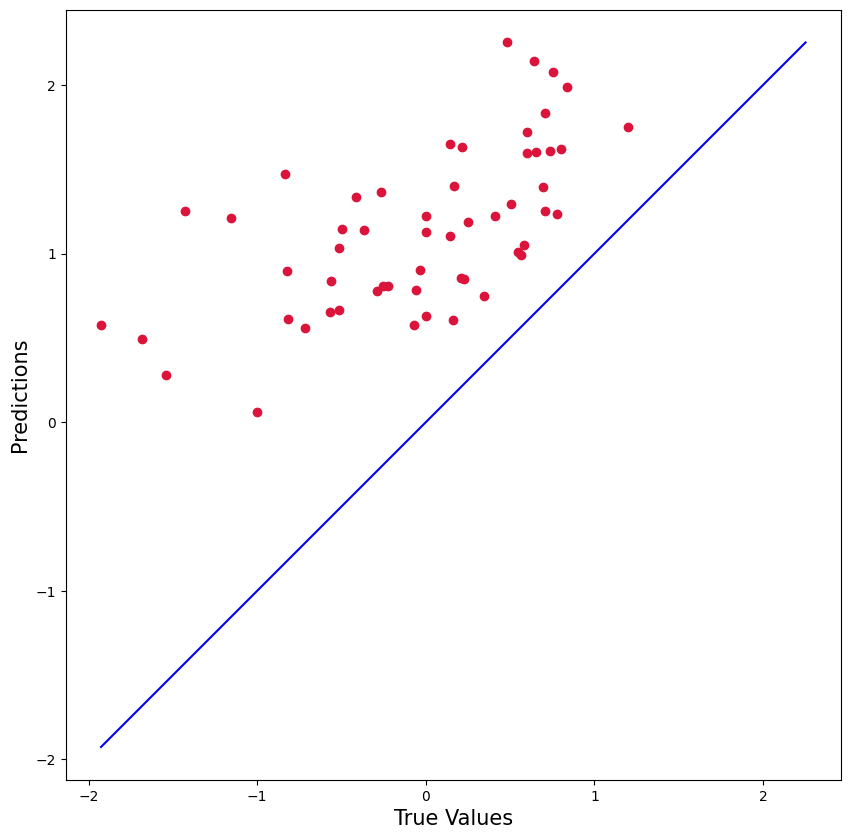

rf 0.6664502164502165


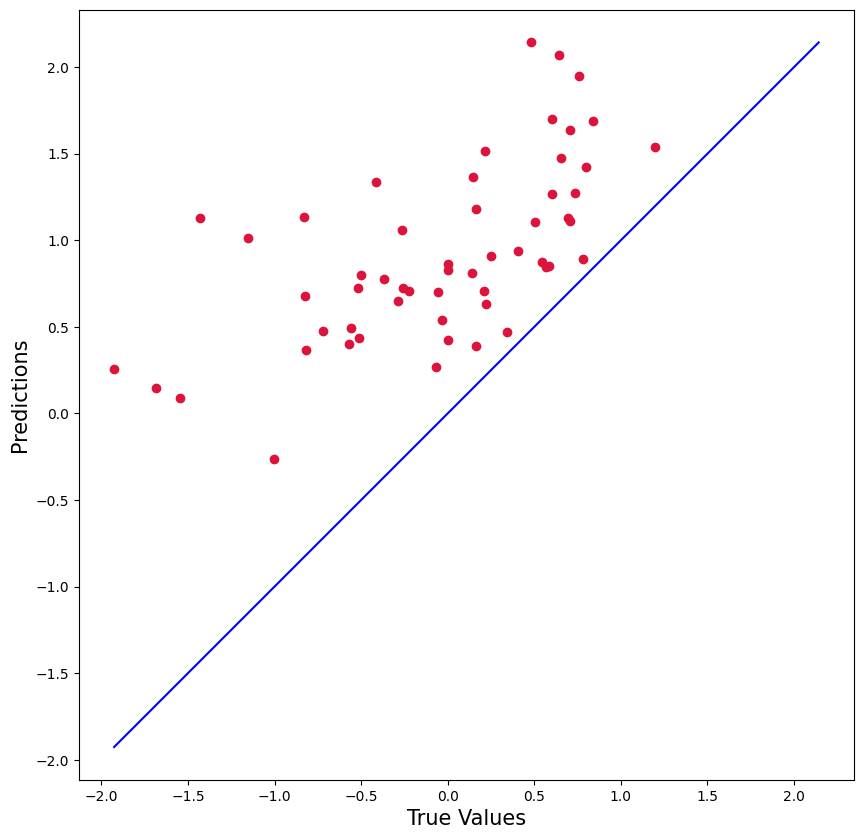

rf 0.6847041847041849


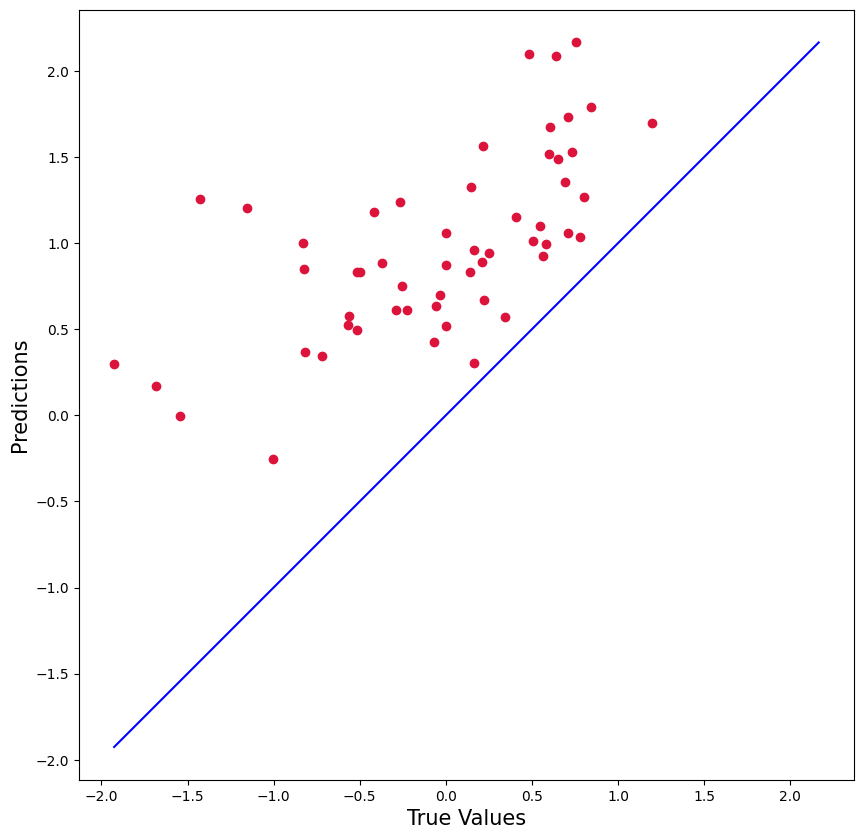

rf 0.6569264069264071


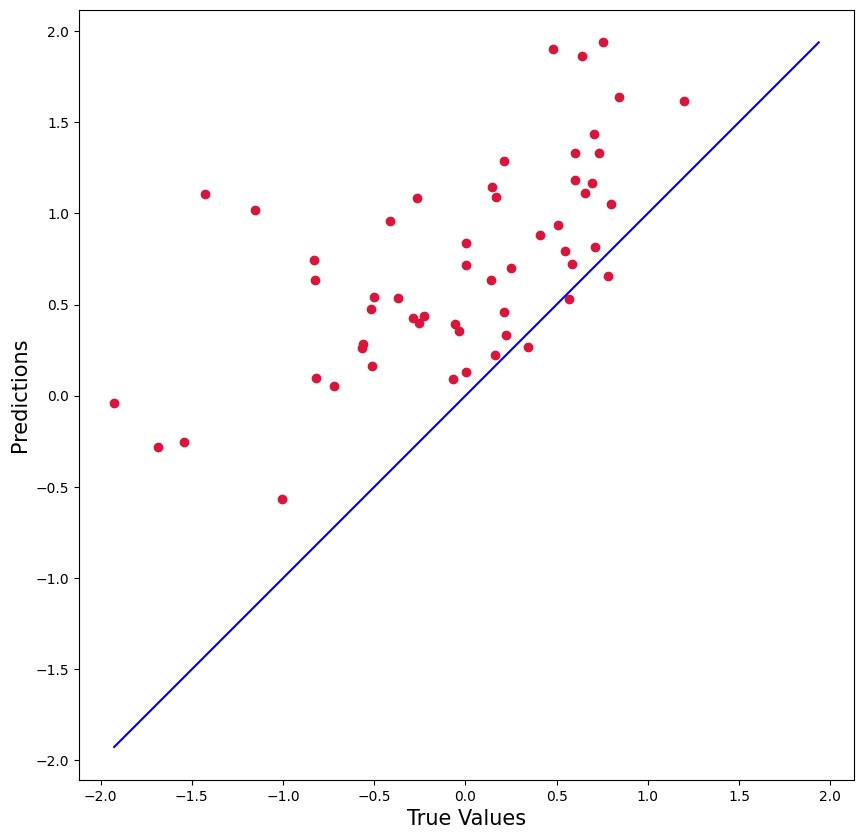

rf 0.638816738816739


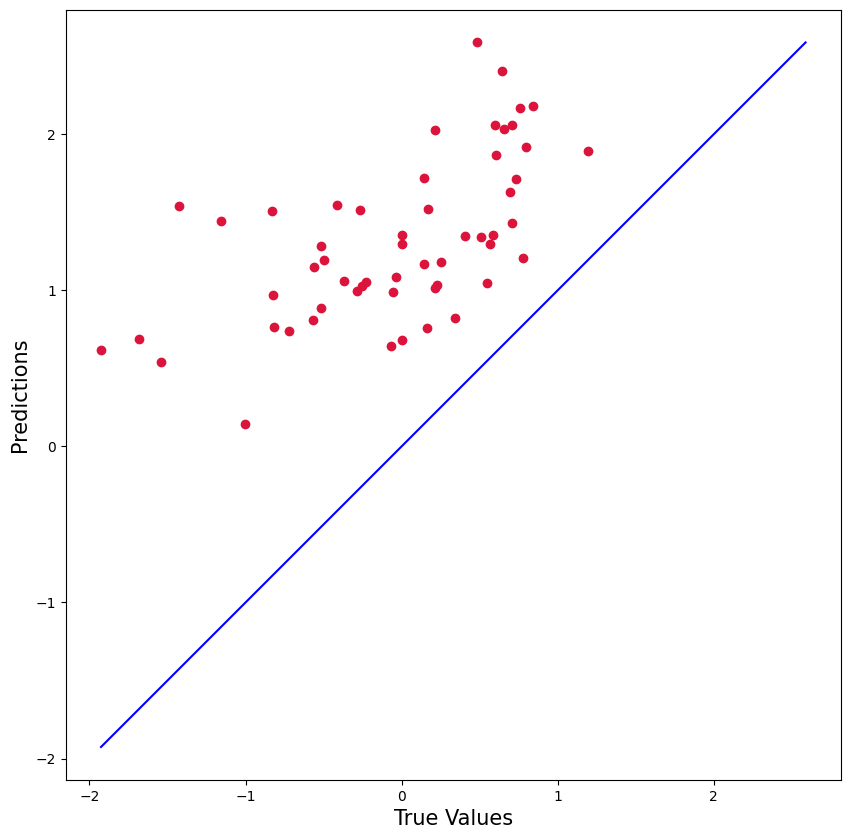

rf 0.6760461760461761


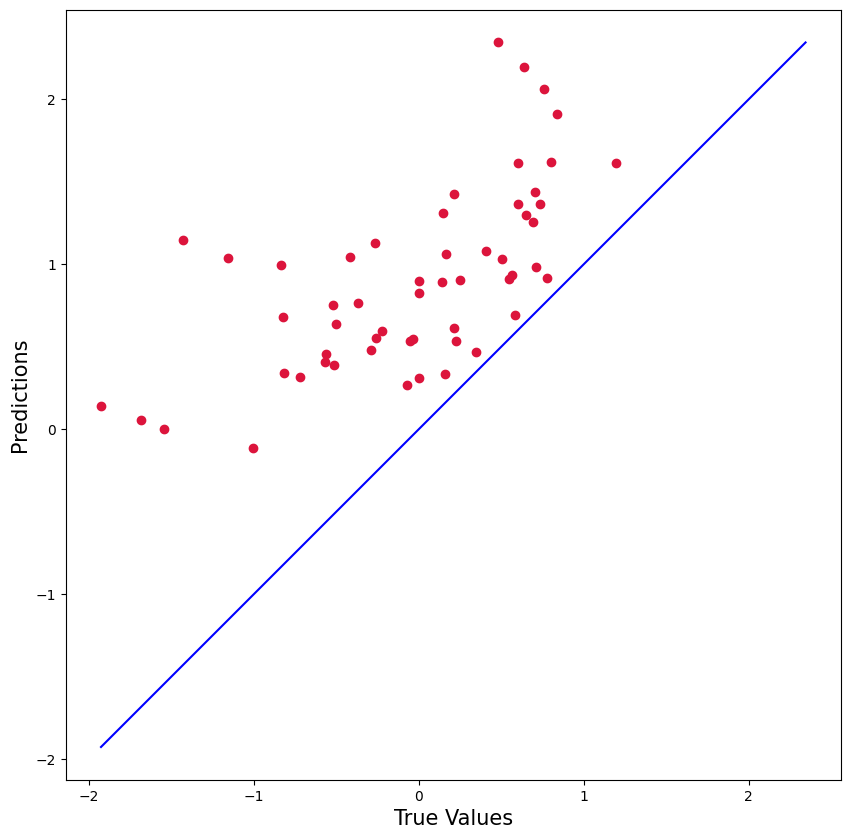

rf 0.647907647907648


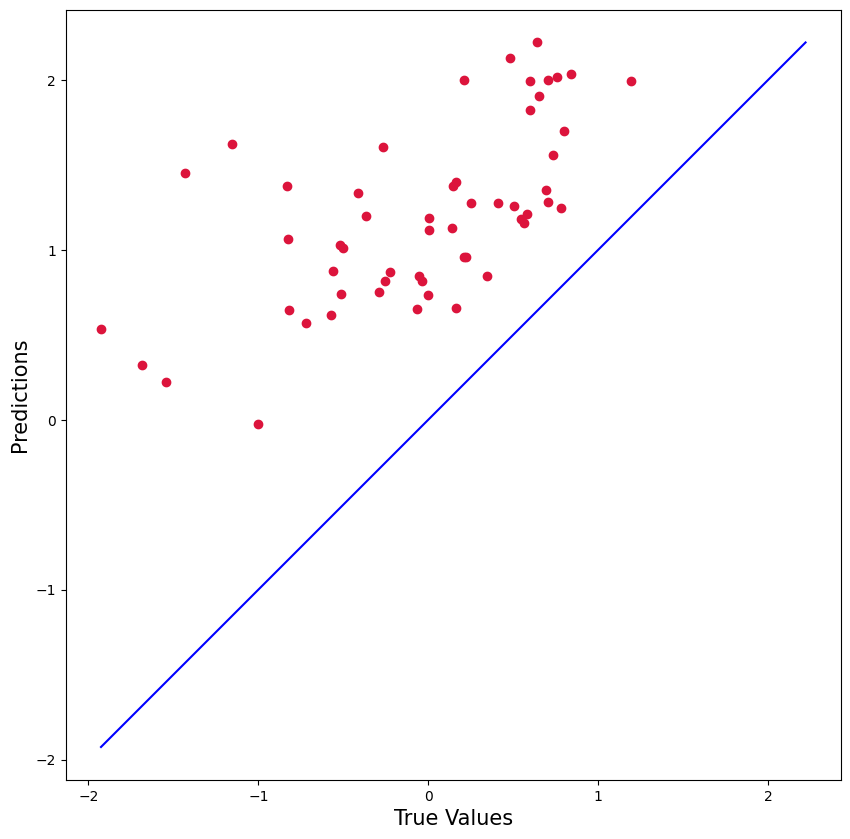

rf 0.6735209235209236


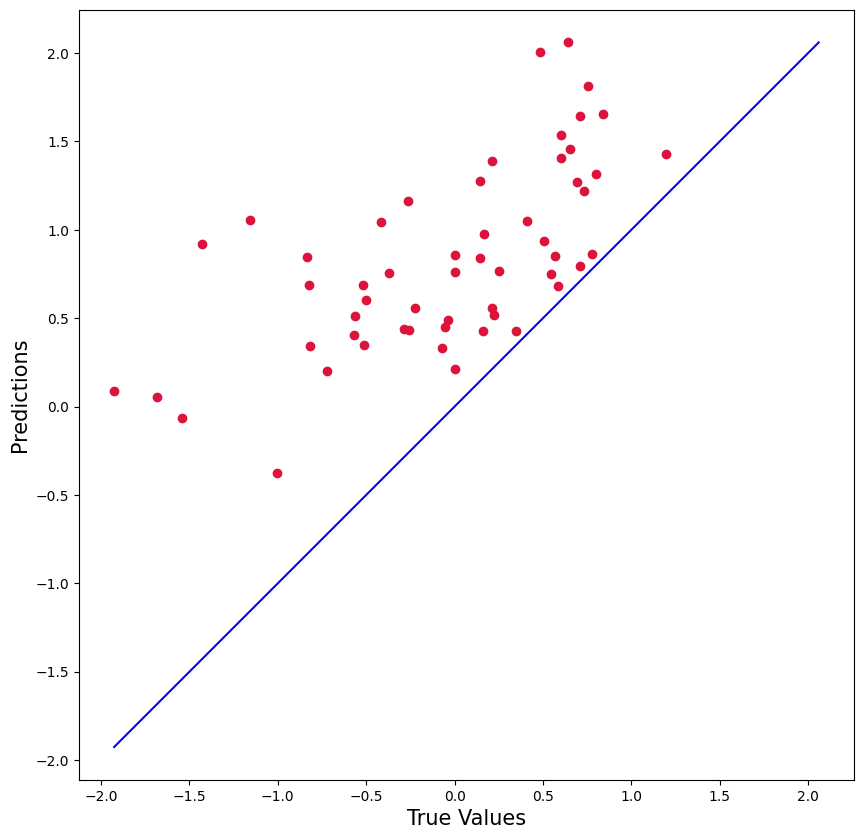

rf 0.6712121212121214


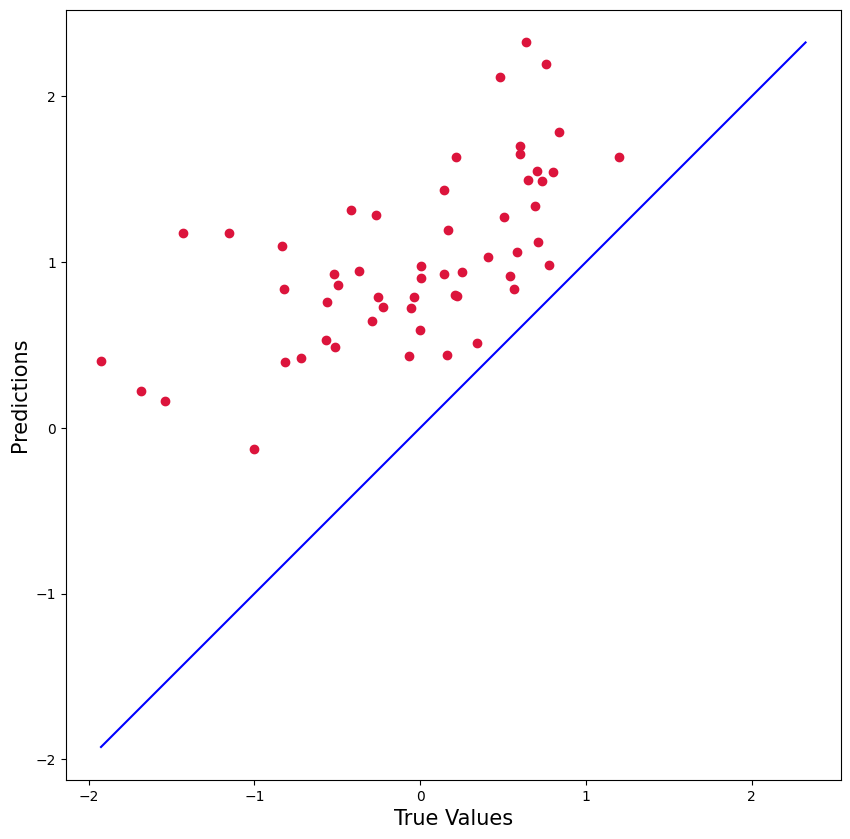

rf 0.640836940836941


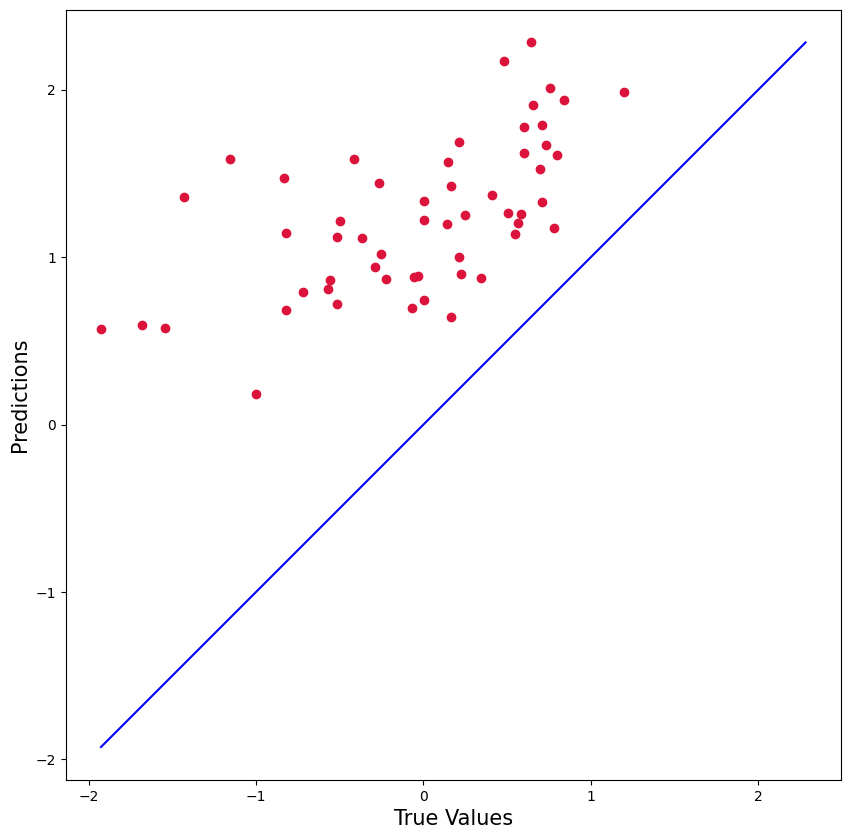

rf 0.6158008658008659


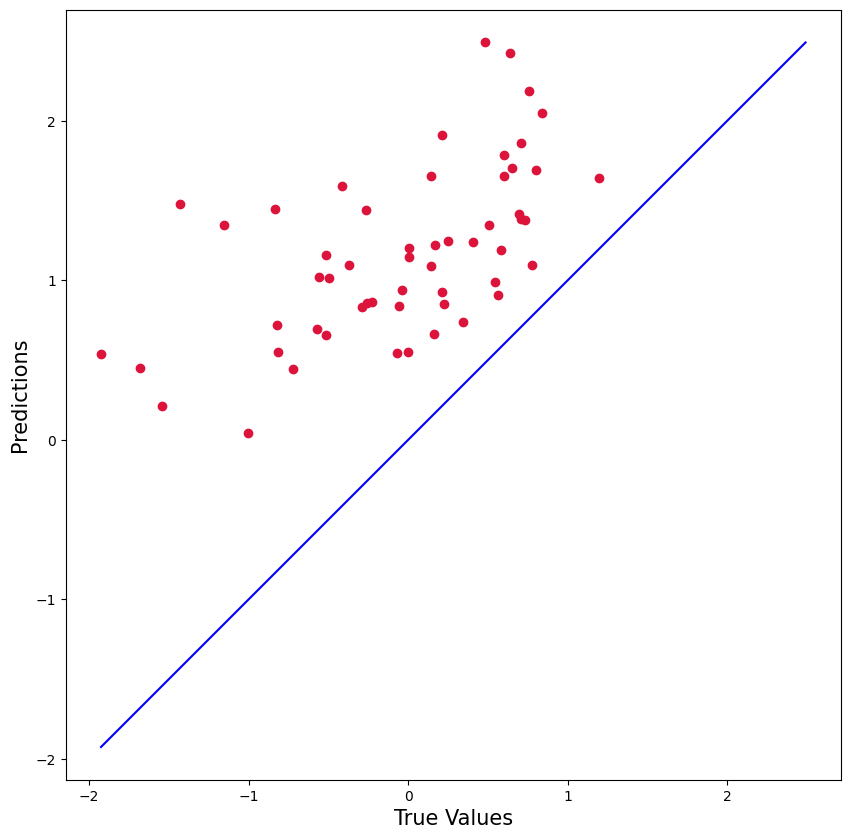

rf 0.6889610389610391


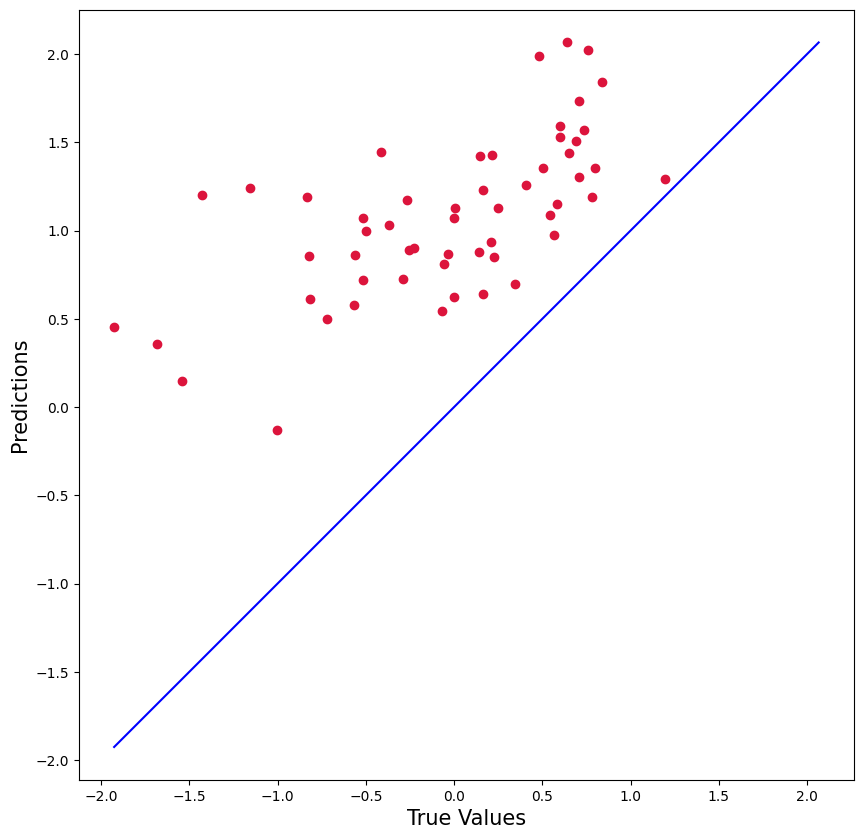

rf 0.7033189033189035


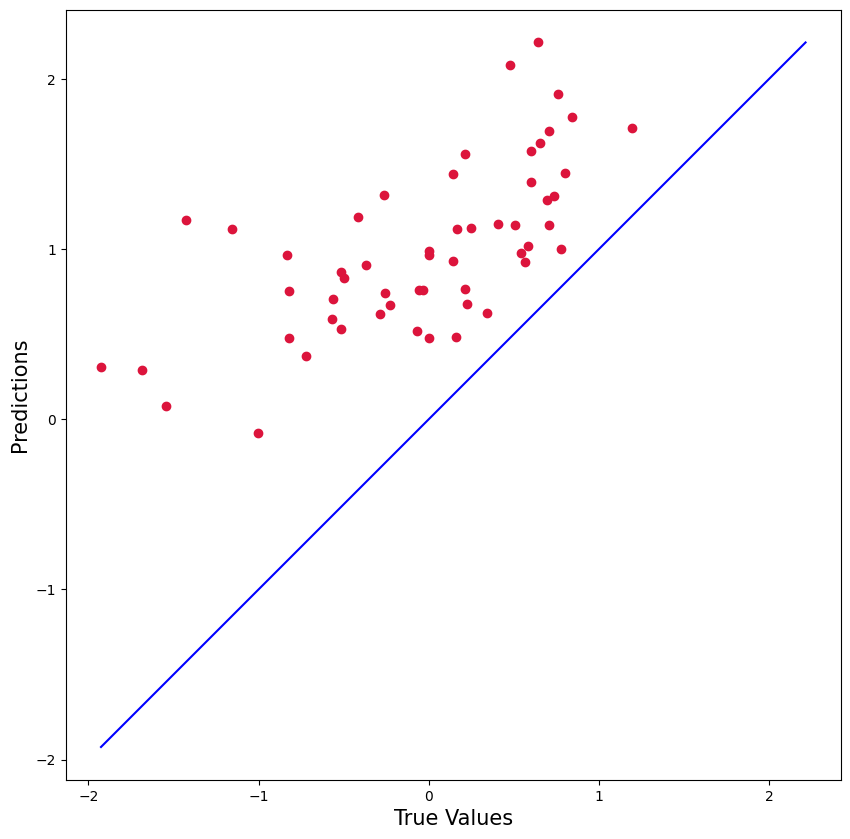

rf 0.6673881673881674


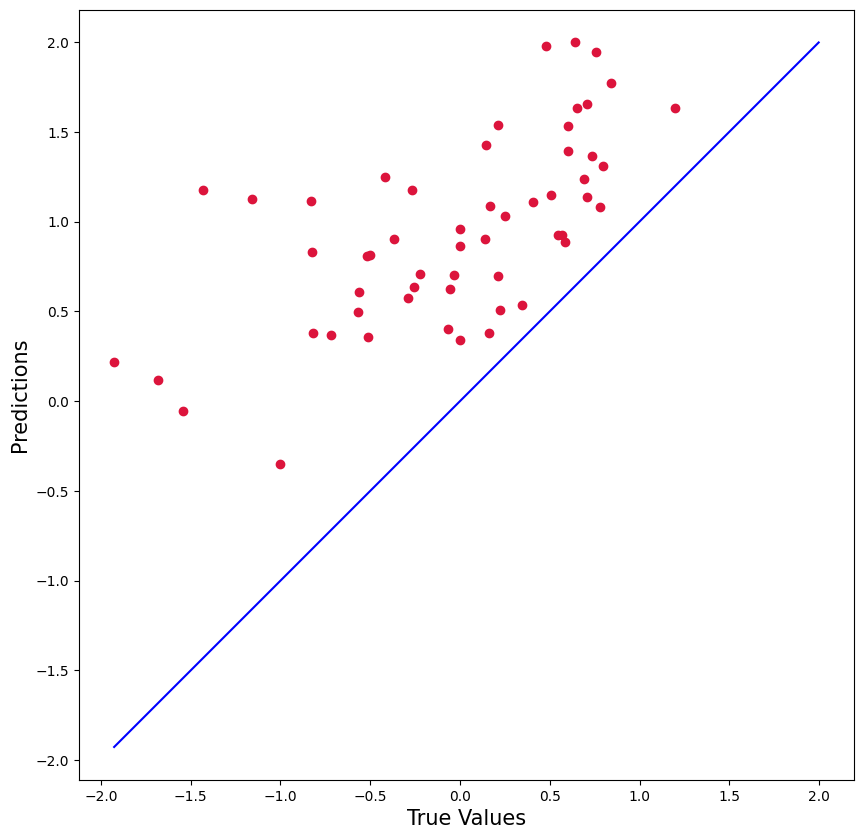

rf 0.6553391053391054


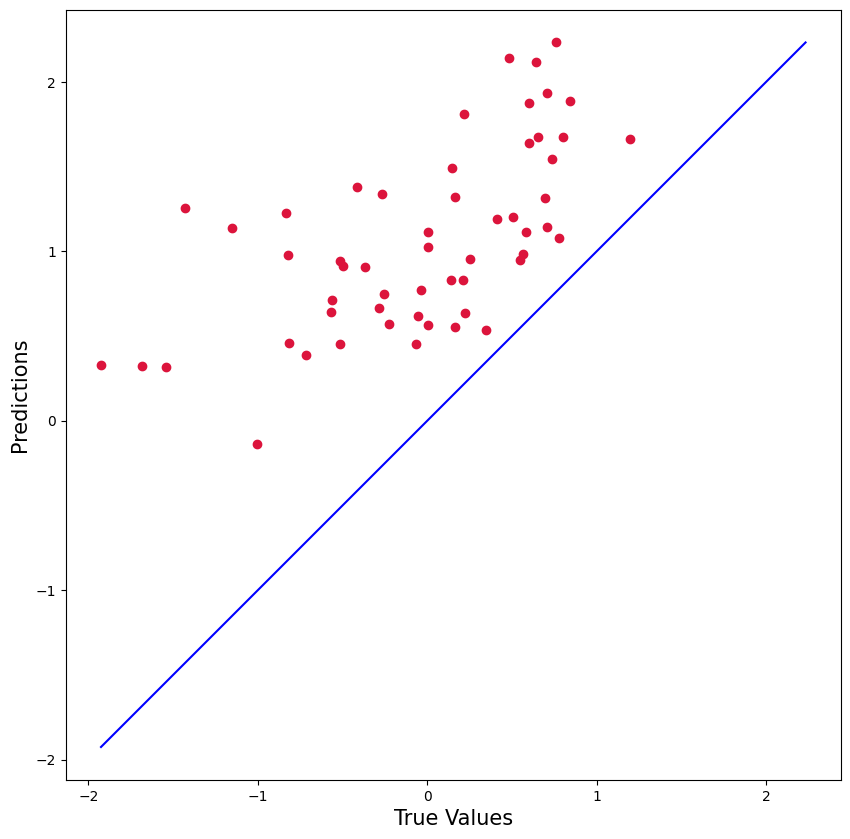

rf 0.6637085137085138


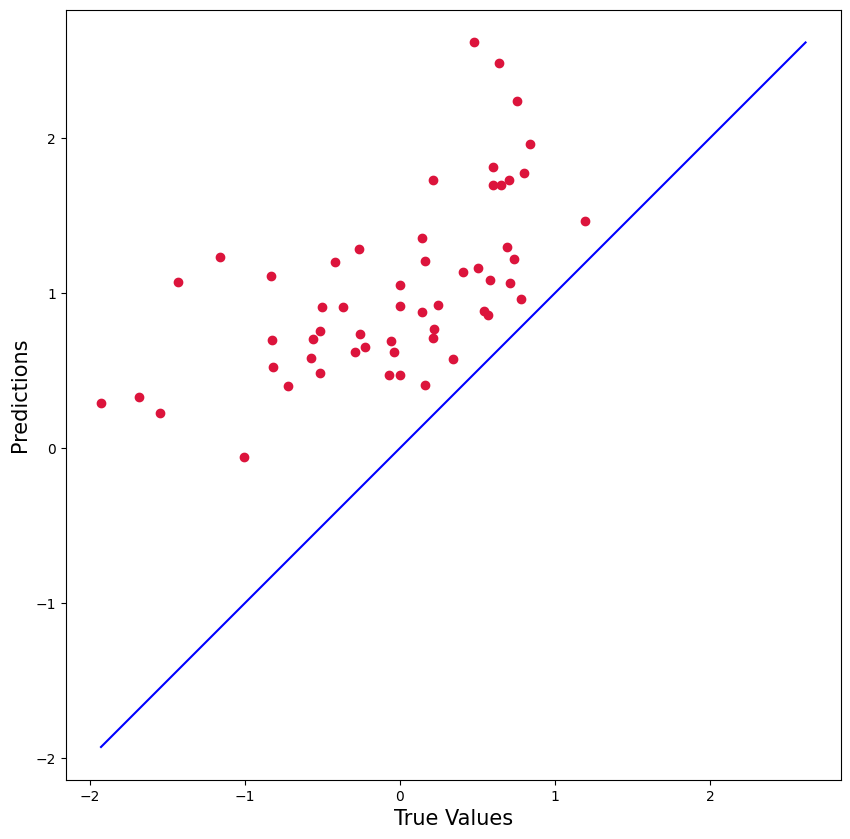

rf 0.6567821067821069


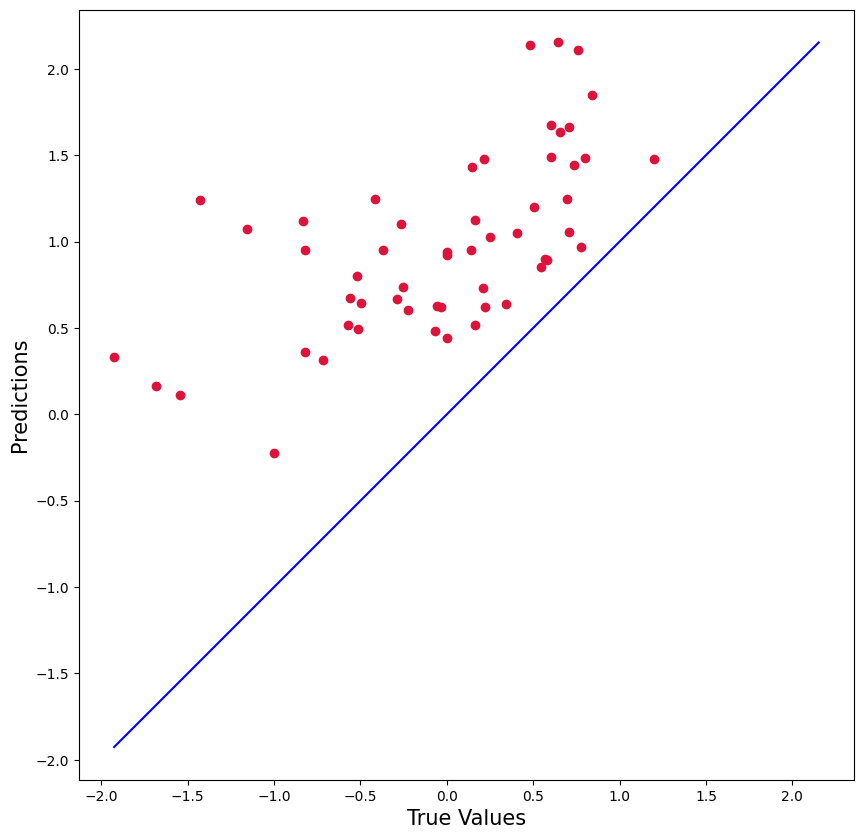

rf 0.6489898989898991


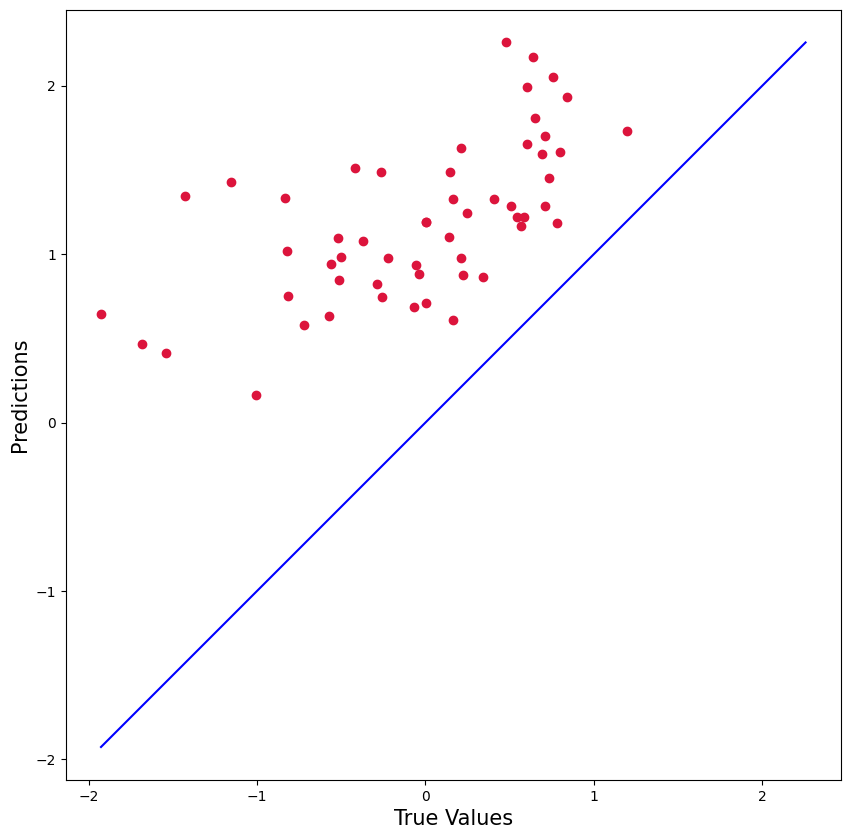

In [ ]:
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
spearman={}
spearman['rf']=[]
spearman['rfet']=[]
spearman['xgb']=[]
spearman['svm']=[]
spearman['combined']=[]
pvalue=[]
for i in range(25):
  regr_rf = RandomForestRegressor()
  regr_rf.fit(X_train,y_train)
  ptest = regr_rf.predict(X_test)
  spear, pval = spearmanr(y_test,ptest)
  spearman['rf'].append(spear)
  pvalue.append(pval)
  print("rf",spear)

  # regr_et = ExtraTreesRegressor(n_estimators=500)
  # regr_et.fit(X_train,y_train)
  # ptest = regr_et.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['rfet'].append(spear)

  # regr_xgb = xgb.XGBRegressor(objective="reg:linear")
  # regr_xgb.fit(X_train,y_train)
  # ptest = regr_xgb.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['xgb'].append(spear)
  # pvalue.append(pval)
  # print("XG",spear)

  # regr_svm = SVR(kernel='rbf',gamma='scale')
  # regr_svm.fit(X_train,y_train)
  # ptest = regr_svm.predict(X_test)
  # spear, pval = spearmanr(y_test,ptest)
  # spearman['svm'].append(spear)


  plot(y_test,ptest)
# for key,value in spearman.items():
#   spearman[key]=np.array(value)
#   print(key)
#   print(round(spearman.key.mean(),2), ' +/- ', round(spearman,key.std(),2))
#   print((pvalue<0.05).sum())

# pvalue = np.array(pvalue)
# print(spearman)
# print(round(spearman.mean(),2), ' +/- ', round(spearman.std(),2))
# print((pvalue<0.05).sum())


In [ ]:
for key,value in spearman.items():
  spearman[key]=np.array(value)
  print(key)
  print(round(spearman[key].mean(),2), ' +/- ', round(spearman[key].std(),2))

# for value in pvalue:
#   print(round(value.mean(),2), ' +/- ', round(value.std(),2))

rf
0.64  +/-  0.02
rfet
nan  +/-  nan
xgb
0.4  +/-  0.0
svm
nan  +/-  nan
combined
0.6  +/-  0.01


<ipython-input-46-9d6664bc4e0f>:4: RuntimeWarning: Mean of empty slice.
  print(round(spearman[key].mean(),2), ' +/- ', round(spearman[key].std(),2))
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**CNN for training, incomplete**

In [ ]:
def model_init():
  model = keras.Sequential([
  keras.Input(shape=(8174,)),
  keras.layers.Dense(4096),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(1024),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(256),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.Dense(64),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  # keras.layers.Dense(32),
  # keras.layers.BatchNormalization(),
  # keras.layers.Activation('relu'),
  keras.layers.Dense(16),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  # keras.layers.Dense(8),
  # keras.layers.BatchNormalization(),
  # keras.layers.Activation('relu'),
  keras.layers.Dense(4),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(1),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('sigmoid'),
])
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=1e-1,
      decay_steps=1000,
      decay_rate=0.95)
  optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

  model.compile(optimizer=optimizer,
              # loss=focal_loss_custom(alpha=0.2, gamma=2.0),
              loss=keras.losses.MeanSquaredError(),
              )
  model.summary()
  return model





Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 4096)              33484800  
                                                                 
 batch_normalization_54 (Bat  (None, 4096)             16384     
 chNormalization)                                                
                                                                 
 activation_45 (Activation)  (None, 4096)              0         
                                                                 
 dense_55 (Dense)            (None, 1024)              4195328   
                                                                 
 batch_normalization_55 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_46 (Activation)  (None, 1024)             

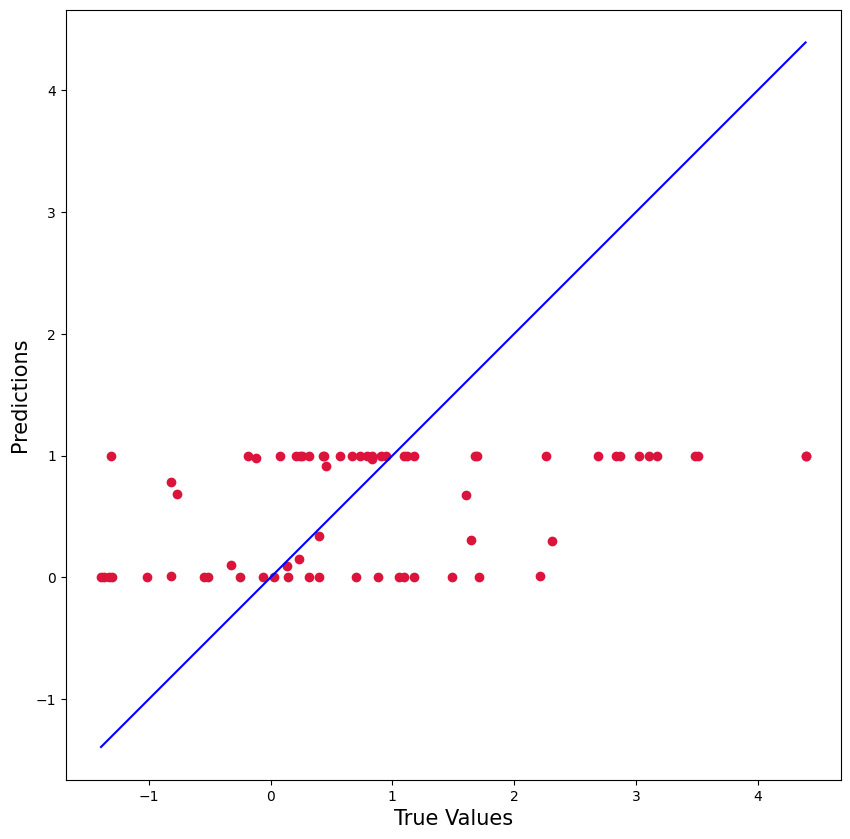

0.47671930614543384


In [ ]:

Xtrain, X_val, ytrain, y_val = train_test_split(X_train, y_train, test_size=0.2)
model=model_init()
history = model.fit(Xtrain, ytrain,
                          epochs = 100,
                          validation_data=(X_val,y_val),
                          shuffle=True)
y_pred = model.predict(X_test)
y_pred.reshape(-1)
plot(y_test,y_pred)
res = spearmanr(y_pred, y_test)
print(res.statistic)

In [ ]:
y_pred.reshape(-1)

array([0.5802902 , 0.452243  , 0.58803827, 0.31611165, 0.462889  ,
       0.5389068 , 0.53274864, 0.4848041 , 0.59414554, 0.65992343,
       0.6876403 , 0.46758586, 0.5547626 , 0.5084817 , 0.52363425,
       0.5182414 , 0.51263905, 0.49464458, 0.5785577 , 0.3047377 ,
       0.5432506 , 0.36846167, 0.55270183, 0.3825169 , 0.5723116 ,
       0.70185274, 0.5107814 , 0.5409802 , 0.51637256, 0.4496245 ,
       0.5610448 , 0.623035  , 0.49240887, 0.6298397 , 0.5961977 ,
       0.51336825, 0.48465127, 0.5800874 , 0.29771495, 0.6286545 ,
       0.6910173 , 0.53156966, 0.55267364, 0.54580593, 0.56971085,
       0.5858512 , 0.5857614 , 0.62587136, 0.59758633, 0.54210186,
       0.47194418, 0.53108484, 0.44213966, 0.4199857 , 0.53279257,
       0.5438843 , 0.4919121 , 0.5536626 , 0.5493911 , 0.5537584 ,
       0.56302524, 0.6884687 , 0.4592874 , 0.39074963, 0.55384934,
       0.4952472 ], dtype=float32)

In [ ]:
from scipy.stats import stats
res = stats.spearmanr(y_pred, y_test)
print(res.statistic)

0.5116314432887367


<ipython-input-66-9d9a467cbe06>:2: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  res = stats.spearmanr(y_pred, y_test)


In [ ]:
len(y_pred)

58222

In [ ]:
len(X_test)

58222

In [ ]:
y_train

array([ 1.3735,  2.7295, -0.024 , -0.326 ,  1.4335,  0.734 ,  2.17  ,
        0.662 ,  0.7145, -0.4155,  0.5415,  0.7785,  0.5325, -0.3415,
        0.769 ,  1.0565,  0.1665,  0.0975,  0.2985,  3.0675,  3.048 ,
        2.0255,  2.886 , -0.329 , -0.0315,  1.51  ,  0.19  ,  2.2465,
       -0.722 , -0.7355,  1.939 ,  3.248 ,  4.394 ,  2.706 ,  1.2535,
        1.213 , -0.6835,  3.377 ,  2.698 ,  2.1455,  1.403 ,  1.1475,
        4.2195, -0.01  ,  0.235 ,  1.7135,  0.7745,  4.256 ,  2.907 ,
       -0.469 , -0.173 ,  0.442 ,  3.9325,  1.387 ,  1.105 ,  0.1915,
        0.767 , -0.9095,  0.936 ,  2.887 ,  0.422 ,  3.3715,  0.9045,
        1.818 ,  0.593 ,  1.134 , -0.787 ,  1.501 ,  0.8745,  2.9885,
        0.093 ,  1.4745,  0.017 ,  0.0385, -0.6605, -0.13  ,  0.5985,
        3.719 ,  3.631 ,  3.989 ,  2.738 ,  2.5175,  2.012 ,  4.394 ,
       -0.782 ,  1.181 ,  1.3575,  2.727 ,  2.4245, -0.0935,  1.964 ,
        1.4785,  3.158 ,  2.8715,  1.214 ,  3.345 ,  1.607 ,  0.1465,
       -0.1965, -0.7

In [ ]:

mask=torch.tensor(y_train)<0
y_train_binary=torch.zeros_like(torch.tensor(y_train))
y_train_binary[mask]=1
y_train_binary.tolist()

mask=torch.tensor(y_test)<0
y_test_binary=torch.zeros_like(torch.tensor(y_test))
y_test_binary[mask]=1
y_test_binary.tolist()

[1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0]

In [ ]:
y_train_binary

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.],
       dtype=torch.float64)

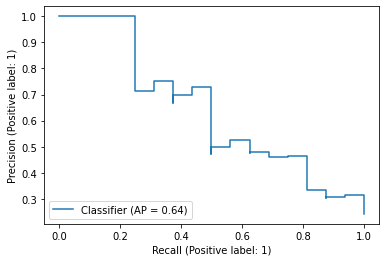

In [ ]:
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train, y_train_binary)
y_pred = classifier.predict_proba(X_test)[:, 1]


# np.save(iter_path, y_pred)
PrecisionRecallDisplay.from_predictions(y_test_binary,y_pred)
plt.show()

In [ ]:
y_pred

array([0.37, 0.41, 0.18, 0.31, 0.3 , 0.38, 0.12, 0.3 , 0.53, 0.29, 0.15,
       0.4 , 0.1 , 0.2 , 0.15, 0.11, 0.53, 0.32, 0.14, 0.46, 0.48, 0.28,
       0.14, 0.4 , 0.08, 0.06, 0.2 , 0.21, 0.16, 0.2 , 0.36, 0.24, 0.79,
       0.17, 0.32, 0.42, 0.31, 0.29, 0.45, 0.06, 0.05, 0.09, 0.34, 0.27,
       0.18, 0.05, 0.08, 0.06, 0.23, 0.21, 0.22, 0.48, 0.39, 0.44, 0.21,
       0.65, 0.08, 0.48, 0.34, 0.4 , 0.08, 0.29, 0.16, 0.31, 0.18, 0.16])

In [ ]:
# combine features of two drugs
# binarilize the features using best threshold
# sigma score: add together
# delta: add together, 1+1=0
# concatenate sigma+delta
# don't binarilize scores
# spiersman corr
indigo_test.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.pkl"))
indigo_train.to_pickle(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_train_feat.pkl"))

In [ ]:
indigo_test = pd.read_csv(os.path.join(GOOGLE_DRIVE_PATH, "data/indigo_test_feat.csv"))
indigo_test

,Unnamed: 0,Drug_1,Drug_2,Score,sigma,delta,feat1,feat2,combined,feat+delta
0,0,AMK,FUS,-0.5495,[0. 0. 0. ... 1. 0. 0.],[0. 0. 0. ... 1. 0. 0.],[0.39 0.125 0.145 ... 0.4 ...,[0.37 0.27333333 0.3 ... 0.473809...,[0. 0. 0. ... 0. 0. 0.],[0.75 0.335 0.3325 ... 0. 0. 0. ]
1,1,AMK,RIF,1.0995,[1. 0. 0. ... 1. 1. 0.],[1. 0. 0. ... 1. 1. 0.],[0.39 0.125 0.145 ... 0.4 ...,[0.44 0.19 0.27 ... 0.476666...,[0. 0. 0. ... 0. 0. 1.],[0.72 0.25166667 0.325 ... 0. ...
2,2,AMK,SPE,2.2150,[0. 0. 0. ... 1. 0. 0.],[0. 0. 0. ... 1. 0. 0.],[0.39 0.125 0.145 ... 0.4 ...,[0.38666667 0.09833333 0.12 ... 0.469166...,[0. 0. 0. ... 1. 1. 0.],[0.74645238 0.30966667 0.31833333 ... 1. ...
3,3,AMK,VAN,1.0560,[0. 0. 0. ... 1. 1. 0.],[0. 0. 0. ... 1. 1. 0.],[0.39 0.125 0.145 ... 0.4 ...,[0.39 0.19 0.15333333 ... 0.566666...,[1. 0. 0. ... 1. 1. 0.],[0.79666667 0.39333333 0.345 ... 1. ...
4,4,CEF,FUS,-0.7660,[0. 0. 0. ... 1. 0. 0.],[0. 0. 0. ... 1. 0. 0.],[0.36 0.21 0.1875 ... 0.4 ...,[0.37 0.27333333 0.3 ... 0.473809...,[1. 0. 0. ... 1. 1. 0.],[0.79666667 0.36333333 0.345 ... 1. ...
...,...,...,...,...,...,...,...,...,...,...
61,61,SPE,TMP,1.6785,[0. 0. 0. ... 2. 0. 0.],[0. 0. 0. ... 0. 0. 0.],[0.38666667 0.09833333 0.12 ... 0.469166...,[0.37785714 0.04 0.21 ... 0.425 ...,[1. 0. 0. ... 1. 1. 0.],[0.72666667 0.30833333 0.38333333 ... 1. ...
62,62,SPE,VAN,0.8350,[0. 0. 0. ... 2. 1. 0.],[0. 0. 0. ... 0. 1. 0.],[0.38666667 0.09833333 0.12 ... 0.469166...,[0.39 0.19 0.15333333 ... 0.566666...,[1. 0. 0. ... 0. 0. 0.],[0.75133333 0.40633333 0.395 ... 0. ...
63,63,TET,VAN,-1.0180,[0. 0. 0. ... 2. 2. 0.],[0. 0. 0. ... 0. 0. 0.],[0.33 0.295 0.28 ... 0.415 ...,[0.39 0.19 0.15333333 ... 0.566666...,[1. 0. 0. ... 0. 0. 0.],[0.74666667 0.44133333 0.36 ... 0. ...
64,64,TOB,VAN,1.6040,[0. 0. 0. ... 1. 1. 0.],[0. 0. 0. ... 1. 1. 0.],[0.37 0.14 0.215 ... 0.39 ...,[0.39 0.19 0.15333333 ... 0.566666...,[2. 0. 0. ... 0. 0. 0.],[0.865 0.41404762 0.48 ... 0. ...
